In [10]:

import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense
from keras.models import Model


# Auto-Encoder

In [11]:


def rgb2gray(img):
  # luminosity transform using Rec. 709: http://www.glennchan.info/articles/technical/rec709rec601/rec709rec601.html
  r, g, b = 0.02126, 0.7152, 0.0722
  return r*img[:,:,0] + g*img[:, :,1] + b*img[:,:,2]

def prep_data(x_train, x_test):

    if len(x_train.shape) > 3:
        x_train = np.array([rgb2gray(img) for img in x_train])
        x_test = np.array([rgb2gray(img) for img in x_test])

    x_train = x_train.astype('float32') / 255.
    x_test = x_test.astype('float32') / 255.
    x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
    x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

    input_dim = x_train.shape[1]
    print(f"Train data shape: {x_train.shape}\nTest data shape: {x_test.shape}\n")

    return x_train, x_test, input_dim

def run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers):
    
    model = ImgAutoEncoder(encoding_dim, input_dim, n_layers)
    return model._fit(x_test, x_train)

class ImgAutoEncoder():
    def __init__(self, encoding_dim, input_dim, n_layers):
        self.encoding_dim = encoding_dim
        self.input_dim = input_dim
        self.n_layers = n_layers
        self.autoencoder, self.encoder, self.decoder = self.deep_autoencoder_model()

    def deep_autoencoder_model(self, dim_scale=2, activation="relu", final_activation="sigmoid"):

        print("Compression factor: {0}".format(float(self.input_dim) / self.encoding_dim))

        # input placeholder
        input_img = Input(shape=(self.input_dim,))

        layer_thickness = range(self.n_layers - 1, -1, -1)
        layer_units = []

        encoded = input_img
        # encoded representation of the layer inputs
        for t in layer_thickness:
            units = (dim_scale**t)*self.encoding_dim
            if units > self.input_dim:
                print(f"Encoding dims [{units}] too large")
                return False, False, False

            layer_units.append(units)
            encoded = Dense(units, activation=activation)(encoded)

        # lossy reconstruction of the layer inputs
        decoded = encoded
        for units in reversed(layer_units[:-1]):
            decoded = Dense(units, activation=activation)(decoded)
        # final decoder layer has the same size as initial layer, sigmoid activation
        decoded = Dense(self.input_dim, activation=final_activation)(decoded)

        # this model maps an input to its reconstruction
        autoencoder = Model(input_img, decoded, name=f"AutoEncoder_{self.n_layers}Layer")
        autoencoder.summary()

        # encoded input
        encoder = Model(input_img, encoded)
        encoded_input = Input(shape=(self.encoding_dim,))

        # dynamically construct decoded input
        decoded_input = encoded_input
        # Iterate over the autoencoder's layers to construct the decoder dynamically
        for layer in autoencoder.layers[-self.n_layers:]:
            decoded_input = layer(decoded_input)

        decoder = Model(encoded_input, decoded_input)

        return autoencoder, encoder, decoder

    def _fit(self, x_test, x_train, epochs=20, batch_size=256, optimizer="adam", loss="binary_crossentropy"):
        self.autoencoder.compile(optimizer=optimizer, loss=loss)
        self.autoencoder.fit(x_train, x_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_data=(x_test, x_test))

        # encode and decode some digits from the *test* set
        encoded_imgs = self.encoder.predict(x_test)
        decoded_imgs = self.decoder.predict(encoded_imgs)

        return encoded_imgs, decoded_imgs

## plotting examples ##

def show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers, n=10):

  size = original_test.shape[1]

  plot_imgs = [
     (original_test, (size, size)),             # display original
     (encoded_imgs, (8, 4)),                    # display encoded imgs
     (decoded_imgs, (size, size))               # display decoded reconstruction
     ]
  n_plots = len(plot_imgs)
  plt.figure(figsize=(20, 2*n_plots))

  for i in range(n):
    for idx, (img, newshape) in enumerate(plot_imgs):
      ax = plt.subplot(n_plots, n, i + 1 + idx*n)
      plt.imshow(img[i].reshape(newshape))
      plt.gray()
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)

  print(f"Deep Encoder, {n_layers} Layers\n")
  plt.show()

def show_decoded_cifar10_imgs(x_test, original_test, encoded_imgs, decoded_imgs, n_layers, n=10):

    size = original_test.shape[1]

    plot_imgs = [
      (original_test, ()),              # display original rgb
     (x_test, (size, size)),            # display grayscale
     (encoded_imgs, (8, 8)),            # display noisy encoded images
     (decoded_imgs, (size, size))       # display reconstruction
     ]
    
    n_plots = len(plot_imgs)
    plt.figure(figsize=(20, 2*n_plots))

    for i in range(n):
        for idx, (img, newshape) in enumerate(plot_imgs):
          ax = plt.subplot(n_plots, n, i + 1 + idx*n)
          if newshape:
            plt.imshow(img[i].reshape(newshape), cmap=plt.cm.gray)
          else:
            plt.imshow(original_test[i,:])
          plt.gray()
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

    # best performance from 2 layers; least overfitting
    print(f"Deep Encoder, {n_layers} Layers\n")
    plt.show()



# Examples

## Detect Anomaly Images (MNIST)

In [19]:


from keras.datasets import mnist

encoding_dim = 32

(x_train, _), (x_test, _) = mnist.load_data()
original_train, original_test = x_train, x_test

x_train, x_test, input_dim = prep_data(x_train, x_test)



### One Layer

Compression factor: 24.5


Model: "AutoEncoder_1Layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        25,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,992 (199.19 KB)

 Trainable params: 50,992 (199.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3762 - val_loss: 0.1896
Epoch 2/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1797 - val_loss: 0.1521
Epoch 3/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1480 - val_loss: 0.1327
Epoch 4/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1313 - val_loss: 0.1206
Epoch 5/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1202 - val_loss: 0.1127
Epoch 6/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1128 - val_loss: 0.1070
Epoch 7/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1075 - val_loss: 0.1027
Epoch 8/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1035 - val_loss: 0.0995
Epoch 9/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1002 - val_loss: 0.0971
Epoch 10/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0980 - val_loss: 0.0953
Epoch 11/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0966 - val_loss: 0.0942
Epoch 12/20
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

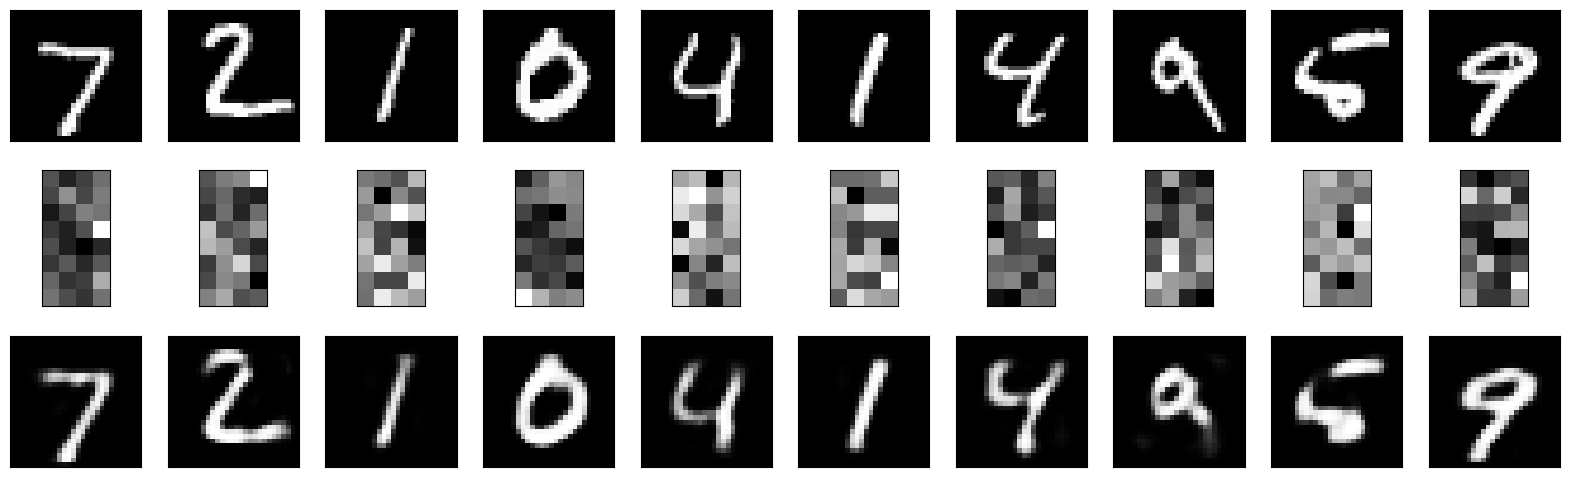

In [17]:

n_layers = 1

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers)


### 2 Layers

Model: "AutoEncoder_2Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 64)                50240     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 784)               50960     
                                                                 
Total params: 105392 (411.69 KB)
Trainable params: 105392 (411.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/

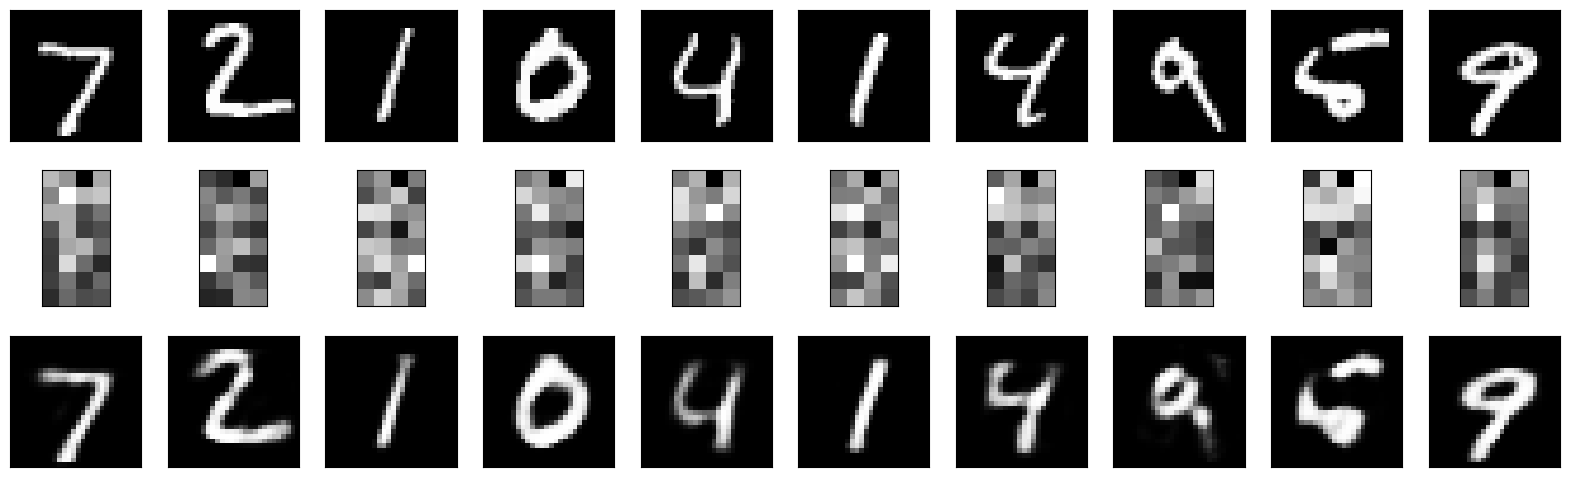

In [6]:

n_layers = 2

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers)


### 3 Layers

Model: "AutoEncoder_3Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 64)                2112      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 784)        

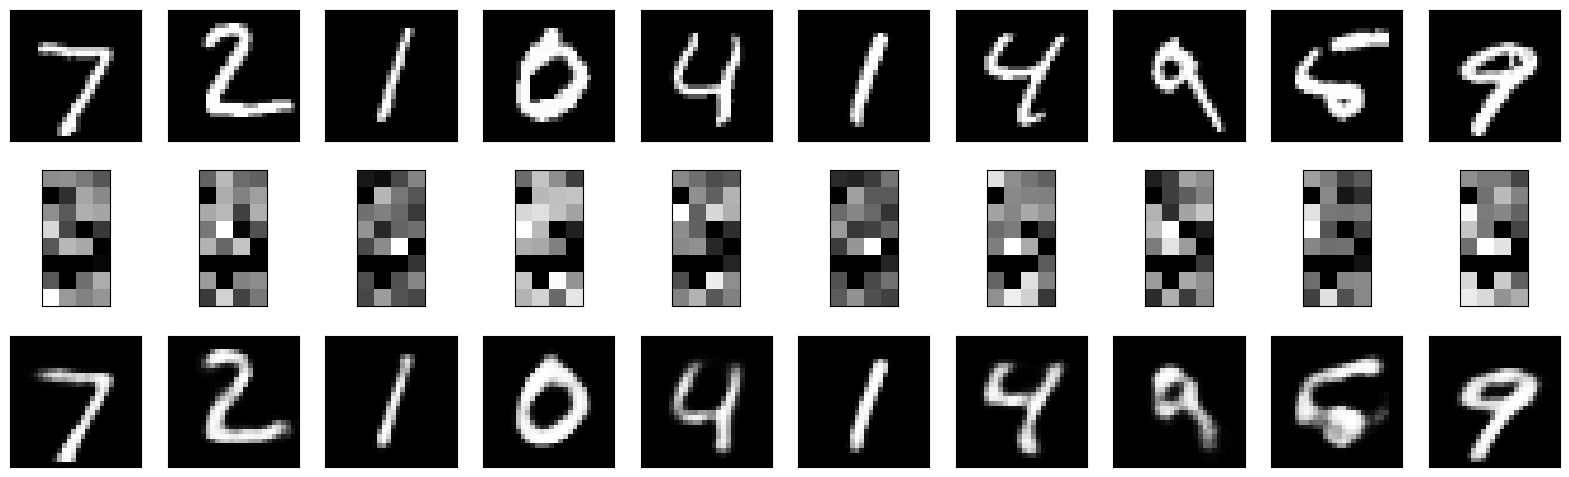

In [7]:

n_layers = 3

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers)


### 4 Layers


Model: "AutoEncoder_4Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_12 (Dense)            (None, 256)               200960    
                                                                 
 dense_13 (Dense)            (None, 128)               32896     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 64)                2112      
                                                                 
 dense_17 (Dense)            (None, 128)        

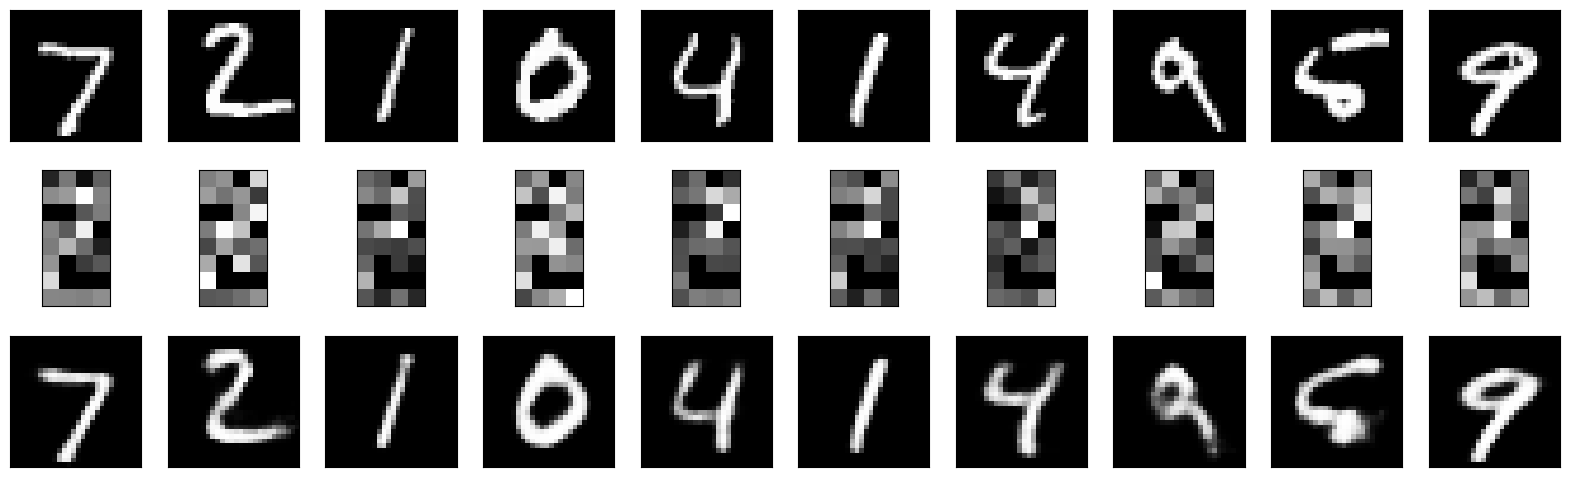

In [8]:

n_layers = 4

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers)


### 5 Layers


Model: "AutoEncoder_5Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_20 (Dense)            (None, 512)               401920    
                                                                 
 dense_21 (Dense)            (None, 256)               131328    
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 64)                8256      
                                                                 
 dense_24 (Dense)            (None, 32)                2080      
                                                                 
 dense_25 (Dense)            (None, 64)         

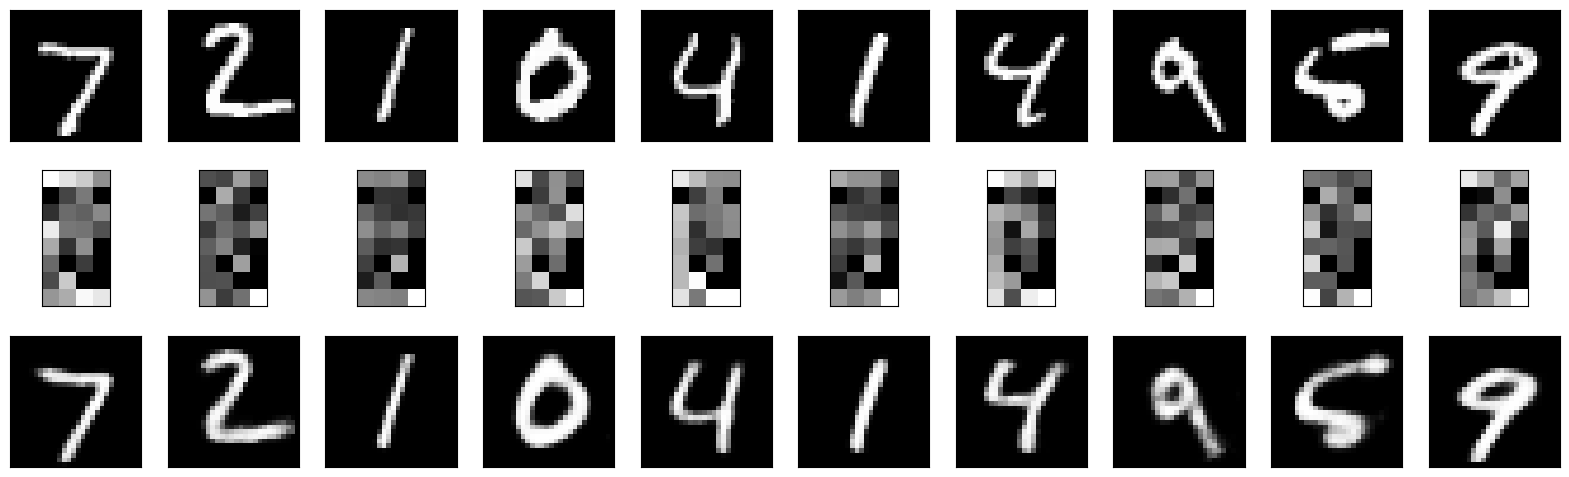

In [9]:

n_layers = 5

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_mnist_imgs(original_test, encoded_imgs, decoded_imgs, n_layers)


## Detect Anomaly Images (CIFAR10)

In [20]:


from keras.datasets import cifar10

encoding_dim = 64

(x_train, _), (x_test, _) = cifar10.load_data()
original_train, original_test = x_train, x_test

x_train, x_test, input_dim = prep_data(x_train, x_test)



### 1 Layer

Model: "AutoEncoder_1Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_30 (Dense)            (None, 64)                65600     
                                                                 
 dense_31 (Dense)            (None, 1024)              66560     
                                                                 
Total params: 132160 (516.25 KB)
Trainable params: 132160 (516.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
196/196 [==============================] - 2s 4ms/step - loss: 0.6486 - val_loss: 0.6346
Epoch 2/20
196/196 [==============================] - 1s 3ms/step - loss: 0.6246 - val_loss: 0.6183
Epoch 3/20
196/196 [==============================] - 1s 3ms/step - loss

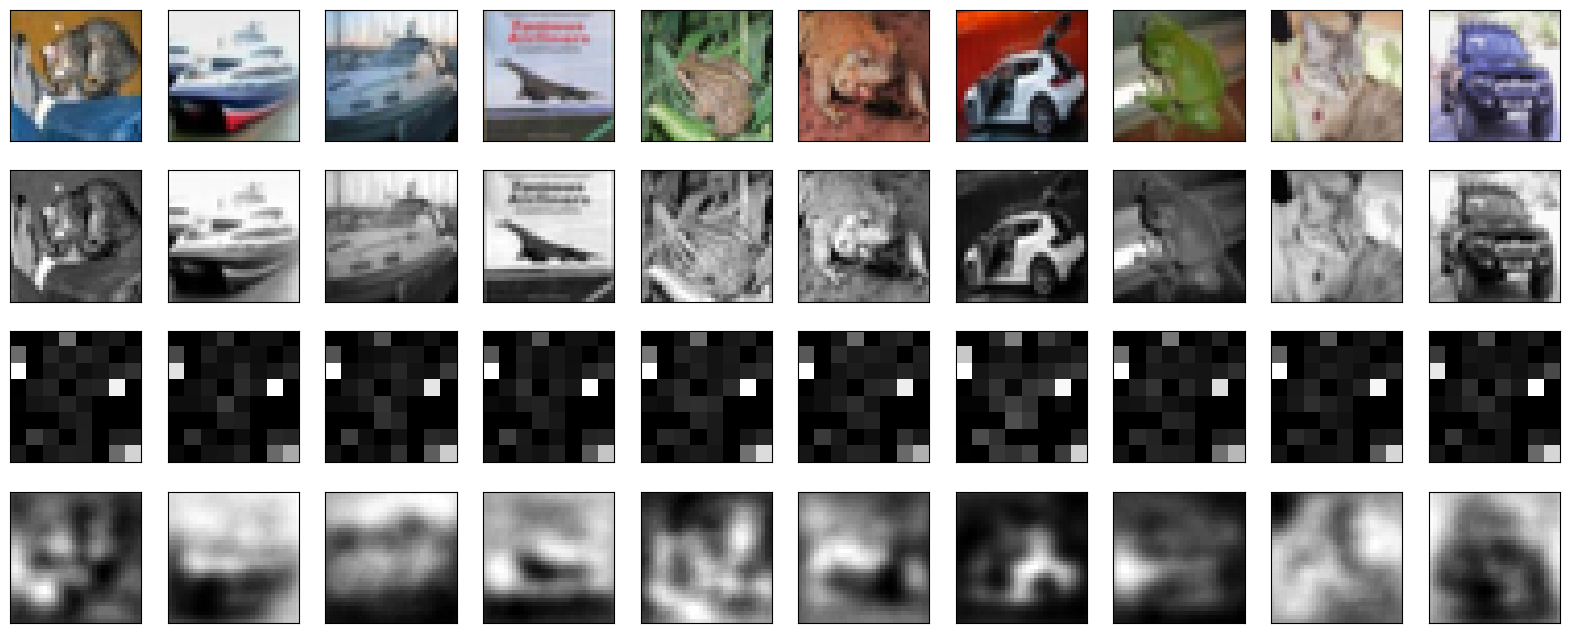

In [11]:

n_layers = 1

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_cifar10_imgs(x_test, original_test, encoded_imgs, decoded_imgs, n_layers)


### 2 Layers

Model: "AutoEncoder_2Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_32 (Dense)            (None, 128)               131200    
                                                                 
 dense_33 (Dense)            (None, 64)                8256      
                                                                 
 dense_34 (Dense)            (None, 128)               8320      
                                                                 
 dense_35 (Dense)            (None, 1024)              132096    
                                                                 
Total params: 279872 (1.07 MB)
Trainable params: 279872 (1.07 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1

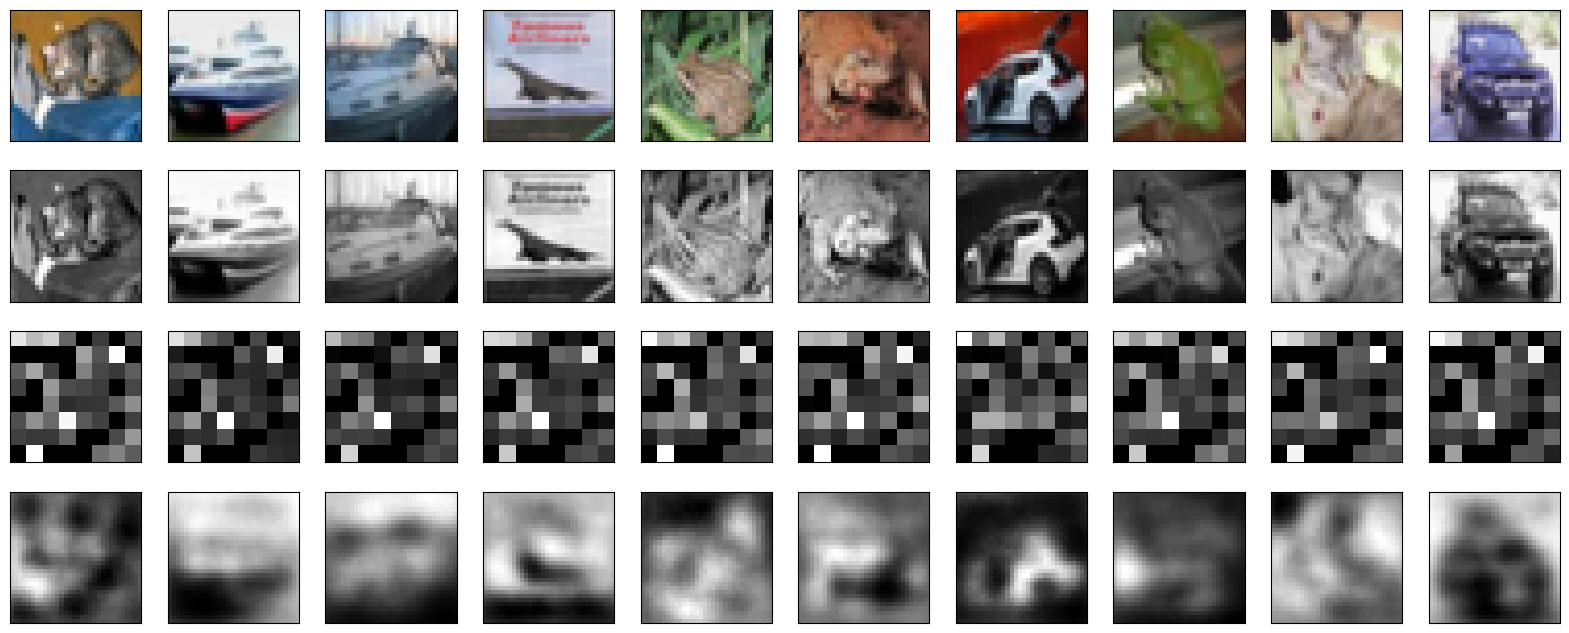

In [12]:

n_layers = 2

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_cifar10_imgs(x_test, original_test, encoded_imgs, decoded_imgs, n_layers)


### 3 Layers

Model: "AutoEncoder_3Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1024)]            0         
                                                                 
 dense_36 (Dense)            (None, 256)               262400    
                                                                 
 dense_37 (Dense)            (None, 128)               32896     
                                                                 
 dense_38 (Dense)            (None, 64)                8256      
                                                                 
 dense_39 (Dense)            (None, 128)               8320      
                                                                 
 dense_40 (Dense)            (None, 256)               33024     
                                                                 
 dense_41 (Dense)            (None, 1024)       

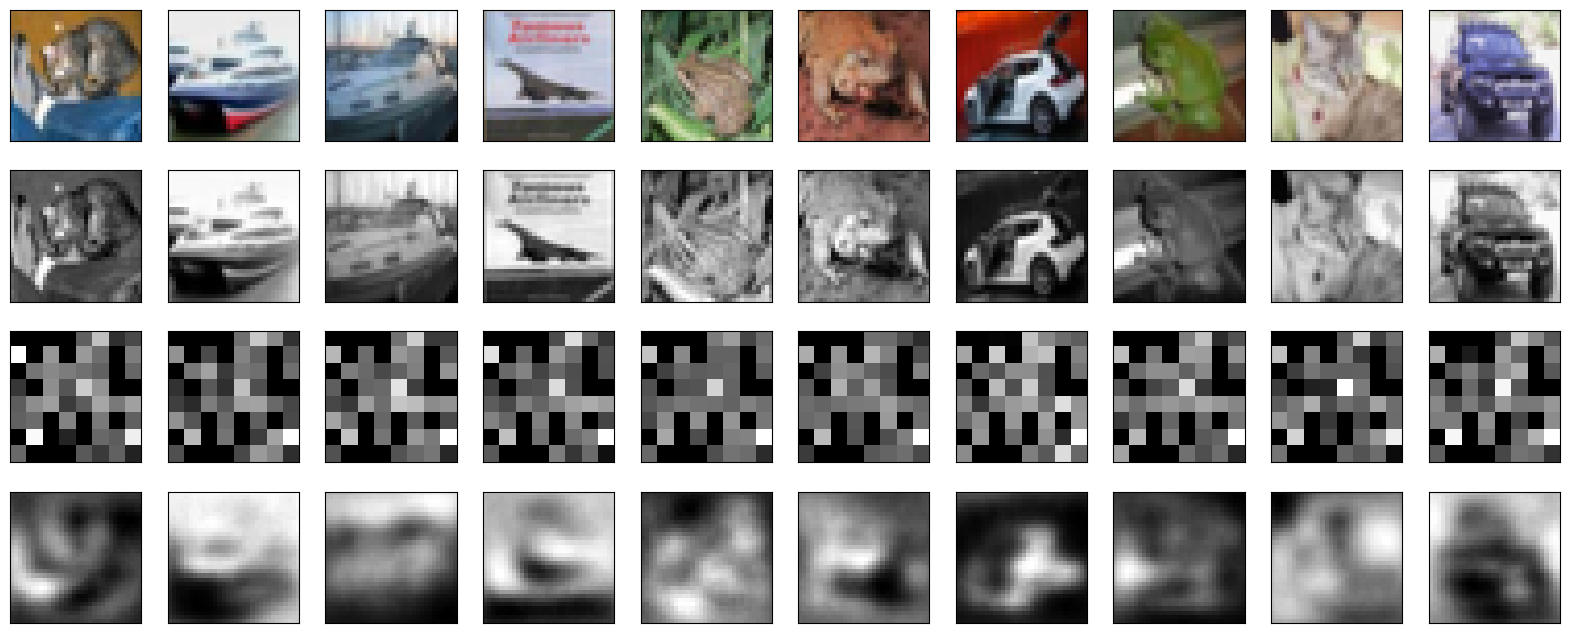

In [13]:

n_layers = 3

encoded_imgs, decoded_imgs = run_autoencoder(encoding_dim, input_dim, x_test, x_train, n_layers)

show_decoded_cifar10_imgs(x_test, original_test, encoded_imgs, decoded_imgs, n_layers)
